In [ ]:
import os
from sklearn.preprocessing import LabelEncoder
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import  to_categorical
from tensorflow.keras.applications import VGG16, VGG19, InceptionV3, MobileNet
from tensorflow.keras.layers import Dense, Rescaling, Resizing, Input, Flatten, Dropout, Conv2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras import models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def test(model, test_x, test_y, size):
  fig, ax = plt.subplots(1, size, figsize=(20, 5))

  for i in range(size):
    idx = random.randint(0, len(test_x)-1)
    ax[i].imshow(test_x[idx])
    pred = model.predict(np.expand_dims(test_x[idx], axis = 0))
    pred = np.argmax(pred, axis = 1)
    y_pred = label_encode.inverse_transform(pred)
    y_true = label_encode.inverse_transform([np.argmax(test_y[idx])])
    ax[i].set_title(f'Label: {y_true[0]}, Predict: {y_pred[0]}')
    ax[i].axis('off')
  plt.show()

def plot(h):
  _, ax = plt.subplots(1, 2, figsize=(20, 5))

  ax[0].plot(h.history['acc'])
  ax[0].plot(h.history['val_acc'])
  ax[0].set_title('model accuracy')
  ax[0].set_ylabel('accuracy')
  ax[0].set_xlabel('epoch')
  ax[0].legend(['train', 'val'])

  ax[1].plot(h.history['loss'])
  ax[1].plot(h.history['val_loss'])
  ax[1].set_title('model loss')
  ax[1].set_ylabel('loss')
  ax[1].set_xlabel('epoch')
  ax[1].legend(['train', 'val'])

In [ ]:
%cp -rf '/content/drive/MyDrive/ML/archive.zip' '/content/'

In [ ]:
!unzip '/content/archive.zip'
from IPython.display import clear_output
clear_output()

In [ ]:
%cp -rf '/content/drive/MyDrive/ML/asl_alphabet_train.zip' '/content/'

In [ ]:
!unzip '/content/asl_alphabet_train.zip'
from IPython.display import clear_output
clear_output()

In [ ]:
path = '/content/asl_alphabet_train/asl_alphabet_train/'
label_encode = LabelEncoder().fit(os.listdir(path))

In [ ]:
os.listdir(path)

['Z',
 'K',
 'B',
 'F',
 'P',
 'I',
 'X',
 'D',
 'E',
 'T',
 'O',
 'J',
 'H',
 'R',
 'Y',
 'Q',
 'M',
 'U',
 'del',
 'C',
 'W',
 'L',
 'nothing',
 'V',
 'G',
 'space',
 'S',
 'A',
 'N']

In [ ]:
train_x = []
train_y = []
for i in os.listdir(path):
  x = 0
  for j in os.listdir(path+i):
    if x == 1500:
      break
    img = plt.imread(f'{path}{i}/{j}')
    train_x.append(img)
    train_y.append(i)
    x += 1

In [ ]:
train_x = np.array(train_x)
train_y = label_encode.fit_transform(train_y)
train_x.shape, train_y.shape

((43500, 200, 200, 3), (43500,))

In [ ]:
order = [i for i in range(len(train_x))]
random.shuffle(order)
train_x = train_x[order]
train_y = train_y[order]

In [ ]:
train_y = to_categorical(train_y, num_classes=len(label_encode.classes_))

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size = 0.2)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.2)

In [ ]:
InceptionV3().summary()

96124928/96112376 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

In [ ]:
inp = Input(shape=(200, 200, 3))
resize = Resizing(299, 299)(inp)
rescal = Rescaling(1/255)(resize)
pretrain = InceptionV3(input_tensor=rescal)
pretrain.trainable = False
x = Flatten()(pretrain.layers[-2].output)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(len(label_encode.classes_), activation='softmax')(x)

model_Inception = Model(inputs = inp, outputs = x)
model_Inception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 resizing (Resizing)            (None, 299, 299, 3)  0           ['input_2[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 299, 299, 3)  0           ['resizing[0][0]']               
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 149, 32  864         ['rescaling[0][0]']          

In [ ]:
model_Inception.compile(optimizer=Adam(), loss = categorical_crossentropy, metrics=['acc'])
inception = model_Inception.fit(train_x, train_y, batch_size=64, epochs=10, validation_data=(val_x, val_y))
model_Inception.save('/content/drive/MyDrive/ML/model.h5')

Epoch 1/10
435/435 [==============================] - 6315s 15s/step - loss: 1.7078 - acc: 0.4828 - val_loss: 0.5293 - val_acc: 0.8499
Epoch 2/10
435/435 [==============================] - ETA: 0s - loss: 0.7111 - acc: 0.7638 

In [ ]:
model = models.load_model('/content/drive/MyDrive/ML/model.h5')

In [ ]:
!cp -rf '/content/asl_alphabet_test' '/content/drive/MyDrive/ML'

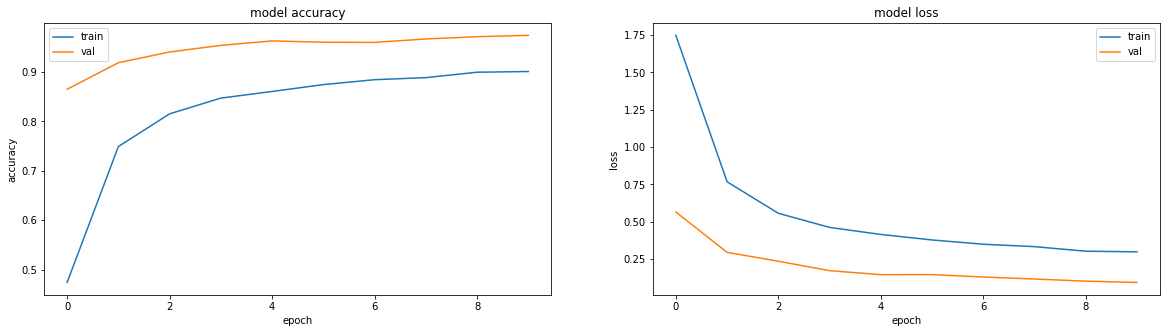

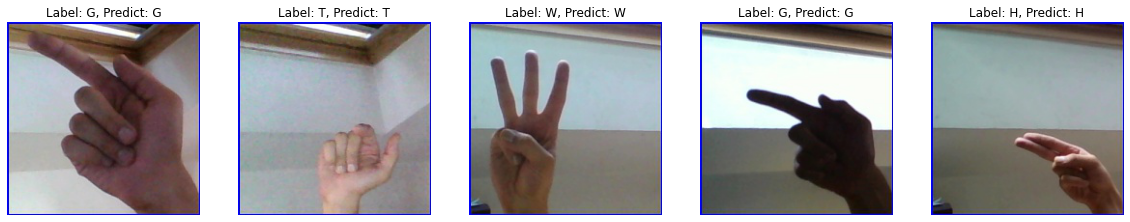

In [ ]:
plot(inception)
test(model_Inception, test_x, test_y, 5)

In [ ]:
MobileNet().summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [ ]:
inp = Input(shape=(200, 200, 3))
resize = Resizing(224, 224)(inp)
rescal = Rescaling(1/255)(resize)
mobile = MobileNet(input_tensor=rescal)
mobile.trainable = False
x = Flatten()(mobile.layers[-3].output)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(len(label_encode.classes_), activation='softmax')(x)

model_MobileNet = Model(inputs = inp, outputs = x)
model_MobileNet.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                           

In [ ]:
model_MobileNet.compile(optimizer=Adam(), loss = categorical_crossentropy, metrics=['acc'])
MobileNet = model_MobileNet.fit(train_x, train_y, batch_size=64, epochs=10, validation_data=(val_x, val_y))

Epoch 1/10
435/435 [==============================] - 81s 179ms/step - loss: 1.3027 - acc: 0.6103 - val_loss: 0.2295 - val_acc: 0.9312
Epoch 2/10
435/435 [==============================] - 76s 176ms/step - loss: 0.4107 - acc: 0.8647 - val_loss: 0.1020 - val_acc: 0.9674
Epoch 3/10
435/435 [==============================] - 76s 174ms/step - loss: 0.2817 - acc: 0.9101 - val_loss: 0.0919 - val_acc: 0.9695
Epoch 4/10
435/435 [==============================] - 76s 176ms/step - loss: 0.2284 - acc: 0.9244 - val_loss: 0.0546 - val_acc: 0.9830
Epoch 5/10
435/435 [==============================] - 82s 188ms/step - loss: 0.1929 - acc: 0.9365 - val_loss: 0.0549 - val_acc: 0.9829
Epoch 6/10
435/435 [==============================] - 76s 175ms/step - loss: 0.1665 - acc: 0.9460 - val_loss: 0.0505 - val_acc: 0.9836
Epoch 7/10
435/435 [==============================] - 82s 188ms/step - loss: 0.1537 - acc: 0.9507 - val_loss: 0.0448 - val_acc: 0.9868
Epoch 8/10
435/435 [==============================] - 7

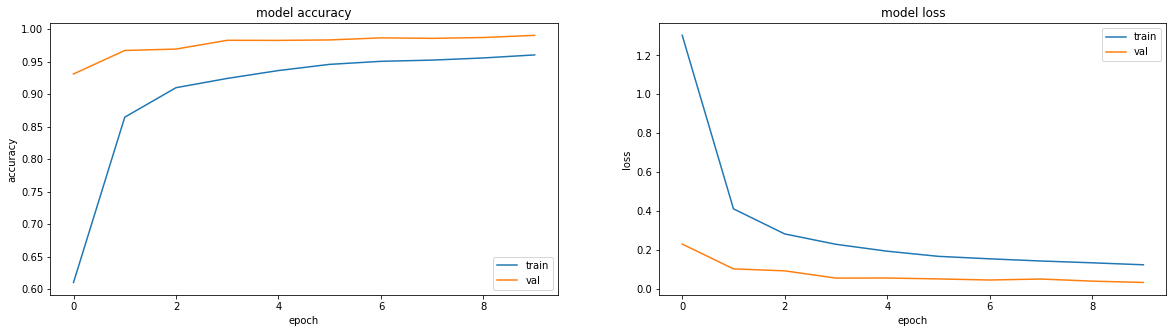

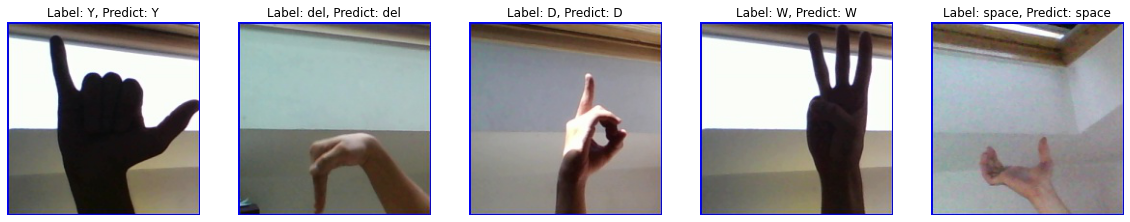

In [ ]:
plot(MobileNet)
test(model_MobileNet, test_x, test_y, 5)